In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sns

In [2]:
df = pd.read_csv("titanic/train.csv")
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [3]:
# drop features
for f in ['Name', 'Ticket', 'Cabin', 'PassengerId']:
    df = df.drop(f,axis=1)

# converts categorical variables into dummy/indicator variables
df_ = pd.get_dummies(df)

# fill in null values
df_ = df_.fillna(df_.mean())
df_.head()

Survived  Pclass   Age  SibSp  Parch     Fare  Sex_female  Sex_male  \
0         0       3  22.0      1      0   7.2500           0         1   
1         1       1  38.0      1      0  71.2833           1         0   
2         1       3  26.0      0      0   7.9250           1         0   
3         1       1  35.0      1      0  53.1000           1         0   
4         0       3  35.0      0      0   8.0500           0         1   

   Embarked_C  Embarked_Q  Embarked_S  
0           0           0           1  
1           1           0           0  
2           0           0           1  
3           0           0           1  
4           0           0           1

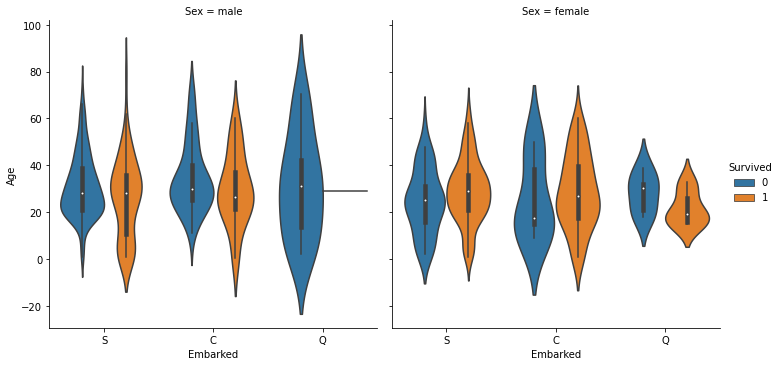

In [4]:
# do some visualization of the dataframe, because violinplots are pretty
sns.catplot(data=df, kind='violin', hue='Survived', x ='Embarked', y ='Age', col='Sex')

In [5]:
# stratify into training, testing
train,test=train_test_split(df_,test_size=0.3,random_state=0, stratify=df_['Survived'])
train.head()

Survived  Pclass        Age  SibSp  Parch     Fare  Sex_female  Sex_male  \
231         0       3  29.000000      0      0   7.7750           0         1   
836         0       3  21.000000      0      0   8.6625           0         1   
639         0       3  29.699118      1      0  16.1000           0         1   
389         1       2  17.000000      0      0  12.0000           1         0   
597         0       3  49.000000      0      0   0.0000           0         1   

     Embarked_C  Embarked_Q  Embarked_S  
231           0           0           1  
836           0           0           1  
639           0           0           1  
389           1           0           0  
597           0           0           1

In [6]:
# create X_train,Y_train, Y_train,X_test
X_train = train.drop(['Survived'],axis=1)
Y_train = train['Survived']
X_test  = test.drop(['Survived'], axis=1)
Y_test  = test['Survived']

# Display
print("Processed DataFrame for Training : Survived is the Target, other columns are features.")
display(train.head())


Processed DataFrame for Training : Survived is the Target, other columns are features.


Survived  Pclass        Age  SibSp  Parch     Fare  Sex_female  Sex_male  \
231         0       3  29.000000      0      0   7.7750           0         1   
836         0       3  21.000000      0      0   8.6625           0         1   
639         0       3  29.699118      1      0  16.1000           0         1   
389         1       2  17.000000      0      0  12.0000           1         0   
597         0       3  49.000000      0      0   0.0000           0         1   

     Embarked_C  Embarked_Q  Embarked_S  
231           0           0           1  
836           0           0           1  
639           0           0           1  
389           1           0           0  
597           0           0           1

In [7]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
random_forest_preds = random_forest.predict(X_test)

print('Accuracy:\t', metrics.accuracy_score(random_forest_preds,Y_test))

Accuracy:	 0.8134328358208955


In [8]:
import lime 
import lime.lime_tabular

In [12]:
X = X_train.values
predict_fn = lambda x: random_forest.predict_proba(x).astype(float)
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names = X_train.columns,
                                                  class_names=['Will Die','Will Survive'],kernel_width=5)

In [10]:
# look at an unlucky passenger
test.loc[[421]]

Survived  Pclass   Age  SibSp  Parch    Fare  Sex_female  Sex_male  \
421         0       3  21.0      0      0  7.7333           0         1   

     Embarked_C  Embarked_Q  Embarked_S  
421           0           1           0

In [14]:
#what happens to this person in our model?
unlucky = X_test.loc[[421]].values[0]
exp = explainer.explain_instance(unlucky,predict_fn,num_features=10)
exp.show_in_notebook(show_all=False)

**Interpretation:**
Model predicted "Not Survived", and hte biggest effect is the person being male.  Also, being a passenger class 3 decreases his chance of survival, but his age increases it. 

In [15]:
test.loc[[310]]

Survived  Pclass   Age  SibSp  Parch     Fare  Sex_female  Sex_male  \
310         1       1  24.0      0      0  83.1583           1         0   

     Embarked_C  Embarked_Q  Embarked_S  
310           1           0           0

In [16]:
lucky = X_test.loc[[310]].values[0]
exp = explainer.explain_instance(lucky, predict_fn,num_features=10)
exp.show_in_notebook(show_all=False)